## Data Clustering Using KDBSCAN

##### Original Paper:
Gholizadeh, N., Saadatfar, H. & Hanafi, N. K-DBSCAN: An improved DBSCAN algorithm for big data. J Supercomput 77, 6214–6235 (2021). https://doi.org/10.1007/s11227-020-03524-3

Steps:
1. Load the dataset
2. Extract the features
3. Perform KMeans clustering using KMeans++ for the initialising centroids
4. Merge clusters based on a defined distance formula and *ε* such that two clusters are merged if the distance between them, *d* < *ε*
5. On each of the clusters obtained in step 4, perform DBSCAN

References:
1. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans
2. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
3. http://archive.ics.uci.edu/dataset/1/abalone
4. https://www.kaggle.com/datasets/abhinand05/magic-gamma-telescope-dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, DBSCAN 
from scipy.spatial.distance import cdist

In [2]:
# Use MAGIC telescopic data - read only the features
X = pd.read_csv('telescope_data.csv').drop(["Unnamed: 0", "class"], axis=1)

In [3]:
# Features
X.head(10)

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620
5,51.6240,21.1502,2.9085,0.2420,0.1340,50.8761,43.1887,9.8145,3.6130,238.0980
6,48.2468,17.3565,3.0332,0.2529,0.1515,8.5730,38.0957,10.5868,4.7920,219.0870
7,26.7897,13.7595,2.5521,0.4236,0.2174,29.6339,20.4560,-2.9292,0.8120,237.1340
8,96.2327,46.5165,4.1540,0.0779,0.0390,110.3550,85.0486,43.1844,4.8540,248.2260
9,46.7619,15.1993,2.5786,0.3377,0.1913,24.7548,43.8771,-6.6812,7.8750,102.2510


In [4]:
# Checking the stats of the features

X.info()
X.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   19020 non-null  float64
 1   fWidth    19020 non-null  float64
 2   fSize     19020 non-null  float64
 3   fConc     19020 non-null  float64
 4   fConc1    19020 non-null  float64
 5   fAsym     19020 non-null  float64
 6   fM3Long   19020 non-null  float64
 7   fM3Trans  19020 non-null  float64
 8   fAlpha    19020 non-null  float64
 9   fDist     19020 non-null  float64
dtypes: float64(10)
memory usage: 1.5 MB


,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
count,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000
mean,53.250154,22.180966,2.825017,0.380327,0.214657,-4.331745,10.545545,0.249726,27.645707,193.818026
std,42.364855,18.346056,0.472599,0.182813,0.110511,59.206062,51.000118,20.827439,26.103621,74.731787
min,4.283500,0.000000,1.941300,0.013100,0.000300,-457.916100,-331.780000,-205.894700,0.000000,1.282600
25%,24.336000,11.863800,2.477100,0.235800,0.128475,-20.586550,-12.842775,-10.849375,5.547925,142.492250
50%,37.147700,17.139900,2.739600,0.354150,0.196500,4.013050,15.314100,0.666200,17.679500,191.851450
75%,70.122175,24.739475,3.101600,0.503700,0.285225,24.063700,35.837800,10.946425,45.883550,240.563825
max,334.177000,256.382000,5.323300,0.893000,0.675200,575.240700,238.321000,179.851000,90.000000,495.561000


In [5]:
# Standardising

scaler  = StandardScaler()
scaled_X = pd.DataFrame(scaler.fit_transform(X[X.columns]), columns = X.columns)

In [6]:
# Scaling/standardizing the features

# scaled_X = X
# scaler = StandardScaler()
# scaled_X[
#     ['Length', 'Diameter', 'Height',
#      'Whole_weight', 'Shucked_weight',
#      'Viscera_weight', 'Shell_weight']] = scaler.fit_transform(scaled_X[
#     ['Length', 'Diameter', 'Height',
#      'Whole_weight', 'Shucked_weight',
#      'Viscera_weight', 'Shell_weight']])

# scaled_X

In [7]:
# creating a dataframe to store scaled features

magic = scaled_X
magic.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
0,-0.577226,-0.336804,-0.381130,0.062759,-0.148923,0.541042,0.224818,-0.405842,0.476816,-1.497866
1,-0.510969,-0.570027,-0.648595,0.820383,1.471776,0.516919,0.260364,-0.490094,-0.815418,0.153125
2,2.568278,6.205858,2.615783,-1.875883,-1.773241,2.044992,-1.478536,-2.183030,1.889224,0.842635
3,-0.694768,-0.687259,-1.029478,1.282069,1.606608,0.532771,-0.333515,-0.355359,-0.658804,-1.031463
4,0.516622,0.476384,0.711157,-0.347506,-0.284660,-0.020200,0.353086,1.036620,-0.881039,2.176427


#### KMeans++ clustering on MAGIC dataset

In [8]:
# Running KMeans++ on abalone data n_clust=3

# km_abalone = KMeans(init='k-means++', n_clusters=3, random_state=69, n_init="auto").fit(abalone)
# km_abalone.labels_       

In [9]:
# number of clusters as proposed in the paper = sqrt(n_samples)
import math
num_clusters = math.floor(np.sqrt([len(magic)])[0])
num_clusters

137

In [10]:
magic

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
0,-0.577226,-0.336804,-0.381130,0.062759,-0.148923,0.541042,0.224818,-0.405842,0.476816,-1.497866
1,-0.510969,-0.570027,-0.648595,0.820383,1.471776,0.516919,0.260364,-0.490094,-0.815418,0.153125
2,2.568278,6.205858,2.615783,-1.875883,-1.773241,2.044992,-1.478536,-2.183030,1.889224,0.842635
3,-0.694768,-0.687259,-1.029478,1.282069,1.606608,0.532771,-0.333515,-0.355359,-0.658804,-1.031463
4,0.516622,0.476384,0.711157,-0.347506,-0.284660,-0.020200,0.353086,1.036620,-0.881039,2.176427
...,...,...,...,...,...,...,...,...,...,...
19015,-0.752189,-0.613988,-0.442072,1.123433,1.617467,0.330947,0.019196,0.126129,-0.966282,-1.164090
19016,-0.573721,-0.843744,-1.180350,0.846640,0.576817,0.699497,0.051761,-0.154268,2.266097,0.717759
19017,0.523923,1.381779,1.318877,-1.305340,-1.445663,-0.084864,0.598262,-0.466509,0.101636,0.839003
19018,1.587757,2.982781,2.473375,-1.564081,-1.324404,0.171204,-2.040597,-3.077206,2.185260,2.870321


In [11]:
# Running KMeans++ with num_clusters
km_magic = KMeans(init='k-means++', n_clusters=num_clusters, random_state=69, n_init='auto', max_iter=4).fit(magic)
km_magic.labels_

array([  5,  69,  85, ..., 112,  35,  96])

In [12]:
# Retrieving KMeans cluster centroids
km_magic.cluster_centers_

array([[-2.52926029e-01, -3.45254084e-01, -2.23634872e-01, ...,
        -1.23526336e-01, -6.77090299e-01, -1.63911395e-01],
       [-6.65849011e-01, -5.82437741e-01, -8.17758055e-01, ...,
        -2.05475474e-01, -3.57687951e-01, -4.46933260e-01],
       [ 7.30076184e-01,  4.58249352e-01,  1.25595462e+00, ...,
         9.20515257e-01, -8.39472615e-01,  1.74270122e+00],
       ...,
       [-6.92875731e-01, -6.05535389e-01, -1.02288546e+00, ...,
        -2.59791067e-02, -6.38175886e-01, -6.82779535e-01],
       [-8.67755255e-01, -7.74348098e-01, -1.09015442e+00, ...,
        -1.37556539e-03,  3.26285943e-01, -2.42580797e-01],
       [ 2.67201785e+00,  1.08284467e+00,  9.68665900e-01, ...,
        -1.38610626e+00,  7.12265897e-01,  6.14726770e-01]])

In [13]:
# Creating a column to store predicted clusters

cluster = []
for val in km_magic.labels_:
    cluster_label = "KC"+str(val)
    cluster.append(cluster_label)
# cluster

In [14]:
# Appending the predicted clusters to our dataset
clustered_df = magic
clustered_df['cluster'] = cluster
clustered_df.head(10)

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,cluster
0,-0.577226,-0.336804,-0.381130,0.062759,-0.148923,0.541042,0.224818,-0.405842,0.476816,-1.497866,KC5
1,-0.510969,-0.570027,-0.648595,0.820383,1.471776,0.516919,0.260364,-0.490094,-0.815418,0.153125,KC69
2,2.568278,6.205858,2.615783,-1.875883,-1.773241,2.044992,-1.478536,-2.183030,1.889224,0.842635,KC85
3,-0.694768,-0.687259,-1.029478,1.282069,1.606608,0.532771,-0.333515,-0.355359,-0.658804,-1.031463,KC21
4,0.516622,0.476384,0.711157,-0.347506,-0.284660,-0.020200,0.353086,1.036620,-0.881039,2.176427,KC2
5,-0.038386,-0.056186,0.176651,-0.756678,-0.729877,0.932494,0.640077,0.459251,-0.920690,0.592534,KC110
6,-0.118105,-0.262977,0.440519,-0.697053,-0.571517,0.217969,0.540212,0.496333,-0.875523,0.338138,KC127
7,-0.624601,-0.459046,-0.577497,0.236712,0.024821,0.573700,0.194327,-0.152636,-1.027996,0.579634,KC57
8,1.014607,1.326507,2.812149,-1.654340,-1.589544,1.937129,1.460879,2.061502,-0.873147,0.728062,KC42
9,-0.153156,-0.380564,-0.521422,-0.233179,-0.211362,0.491289,0.653576,-0.332787,-0.757413,-1.225308,KC5


In [15]:
# Storing the samples in each cluster in a dictionary with the cluster name as key and a dataframe with samples belonging
# to those clusters as the value

cluster_samples = {}
labels = set(cluster)
for label in labels:
    cluster_samples[label] = clustered_df.loc[clustered_df['cluster'] == label]

In [16]:
# We create a similar dictionary to store features of each sample in each cluster

cluster_features = {}
for label in labels:
    cluster_features[label] = cluster_samples[label].drop(['cluster'], axis=1)
cluster_features["KC63"]

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
51,-0.216354,0.045424,0.153164,-1.006667,-1.042976,0.511519,-0.895638,0.914749,-0.441587,0.224515
215,-0.385907,0.149487,0.555630,-1.065745,-1.058360,0.031389,-0.467240,0.377304,-0.983530,-0.786581
275,-0.295091,0.216305,0.819285,-1.023077,-1.029403,0.579487,-0.689119,0.416191,-0.738680,-0.330457
302,-0.219260,-0.105599,0.648100,-0.936101,-0.956105,-0.386703,-0.610792,0.675668,-0.796834,-0.056230
403,0.061214,-0.039594,0.794951,-0.919143,-0.884617,-0.386681,-0.747717,0.468004,-0.851058,0.532183
...,...,...,...,...,...,...,...,...,...,...
17605,-0.121426,1.149996,1.347866,-1.588150,-1.296352,0.133806,-0.881344,1.482025,-0.261772,-0.772674
18494,-0.128458,0.971920,0.681744,-1.265955,-1.242962,-0.639422,-0.860276,1.098550,-0.063123,-1.059992
18524,0.394801,0.592853,0.599643,-0.793329,-0.845706,-0.003501,-1.519035,0.925355,-0.104621,-0.194367
18780,-0.407118,0.076020,0.677089,-0.976034,-1.012209,-0.245540,-0.389089,0.529862,0.271567,0.037896


In [17]:
# Running DBSCAN on each cluster and storing the results
dbscan_clusters = {}

# Running DBSCAN on each cluster:
selected_df = None
for i in range(0, num_clusters):
    label = "KC" + str(i)
    
    current = cluster_features[label] # current dataframe    
    n = len(cluster_features[label]) # total number of samples in the current kmeans cluster
    
    dbscan = DBSCAN(eps=0.6, min_samples=4).fit(cluster_features[label])
    valid_clus = set(dbscan.labels_).difference([-1]) # removing noise points
    numclu = len(set(valid_clus)) # total number of non-noise DBSCAN clusters identified in the current KMeans cluster
    
    current['db_clus'] = dbscan.labels_ # marking each sample with it's dbscan cluster number
    
    db_samples = {}
    if numclu > 0:
        for p in range(numclu):
            db_samples[str(p)] = current.loc[current['db_clus'] == p].drop(['db_clus'], axis=1)

    dbscan_clusters[label] = db_samples

In [18]:
# Checking if everything has worked properly
dbscan_clusters["KC0"]["2"]

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
1069,-0.001311,-0.407404,0.136659,-0.754490,-0.746165,-0.283153,0.269370,0.366707,-0.955628,0.338874
2988,-0.227658,0.101323,0.234419,-0.805910,-0.751595,-0.609525,0.250719,0.494811,-0.795302,-0.339450
4749,-0.180649,-0.176738,0.096031,-0.628128,-0.692775,-0.667209,0.539683,0.805798,-0.582567,-0.345766
6915,-0.027678,-0.229067,-0.252053,-0.616094,-0.669248,-0.853044,-0.065199,0.361282,-0.901612,0.248013
9745,-0.106304,-0.176973,0.087356,-0.666420,-0.705444,-0.663739,0.212136,0.552045,-0.877744,0.110638
9801,-0.474516,-0.248919,-0.308974,-0.557015,-0.606809,-0.902724,0.225469,0.708506,-0.845246,-0.463390
9816,-0.250305,-0.350977,-0.135038,-0.686659,-0.774217,-0.744823,0.244032,0.528661,-0.852537,-0.355829
10107,-0.016520,-0.257243,-0.360393,-0.687206,-0.749785,-0.700301,0.255937,0.756535,-0.561002,-0.675166
11085,-0.394209,-0.196907,-0.085523,-0.589290,-0.597759,-0.235103,0.061365,0.373938,-0.978423,-0.210853
11883,-0.415732,-0.249742,-0.055687,-0.636881,-0.683726,-0.379219,0.220000,0.429904,-0.514184,-0.199506


### Merging clusters

In this step, we examine each of the groups obtained from KMeans clustering to see if any of the clusters can be merged. The authors proposed the following distance formula for calculating pairwise distances between the groups:
<br><br>
<div style="text-align: center;">
    <i>
        <strong>dis_K<sub>ij</sub> = dis_KC<sub>ij</sub> + (dis_r<sub>i</sub> - dis_r<sub>j</sub></strong>
    </i>, where
    <br><br>
    <i><strong>dis_K<sub>ij</sub></strong></i> = distance between clusters <i>i</i> and <i>j</i>,
    <br>
    <i><strong>dis_KC<sub>ij</sub></strong></i> = distance between the cluster centers of clusters <i>i</i> and <i>j</i>,
    <br>
    <i><strong>dis_r<sub>i</sub></strong></i> = distance of the furthest point in cluster <i>i</i> to the corresponding center, and
    <br>
    <i><strong>dis_r<sub>j</sub></strong></i> = distance of the furthest point in cluster <i>j</i> to the corresponding center
</div>

In [19]:
# We will be using the Euclidean distance when calculating distance between KMeans groups
from scipy.spatial import distance

In [20]:
# Defining a function to calculate distance between two groups/clusters
def minC_distance(a, b):
    return np.min(cdist(a, b))

##### Saving centers and farthest point of each cluster in a dictionary

In [22]:
km_centers = {}
farthest_point = {}

for i in range(0, num_clusters):
    # finding the center of cluster i
    label = "KC" + str(i)
    center = km_magic.cluster_centers_[i]
    km_centers[label] = center
    
    # iterating through each sample in cluster i to find the farthest point
#     print(cluster_features[label].head())
    samples = cluster_features[label].drop(['db_clus'], axis=1).to_numpy() 
    max_dist = 0
#     print(samples.shape)
    for sample in samples:        
        dist = distance.euclidean(np.array(sample), center)
        if dist >= max_dist:
            farthest_point[label] = {"point": np.array(sample),"distance": dist}
            max_dist = dist

##### Computing pairwise distances of each cluster using the distance formula defined earlier

In [23]:
pairwise_distance = np.full((num_clusters, num_clusters), np.inf)

for i in range(0, num_clusters):
    ci = "KC" + str(i) # label of cluster i
    
    for j in range(i + 1, num_clusters):
        cj = "KC" + str(j) # label of cluster j
        if i == j:
            pairwise_distance[i][j] = 0
        else:
            pairwise_distance[i][j] = distance.euclidean(km_centers[ci], km_centers[cj]) 
            + (farthest_point[ci]["distance"] - farthest_point[cj]["distance"])
pairwise_distance

# utility function that returns the pairwise distance of two groups
def pair_dist_group(i, j):
    return pairwise_distance[i][j]

In [24]:
# scratchpad
# s = '2'
# type(int(s))

In [25]:
# cluster_samples - contains list of KMeans groups
# dbscan_clusters - contains dbscan clusters for each KMeans group

counter = 1
flag = {}
flag_ref = {}
k = num_clusters # number of kmeans groups
epsilon = 3.0 # distance above which clusters will be pruned
MinPts = 4

# temp = []

for a in range(k-1):
    label_k1 = "KC" + str(a)
    num_1 = len(dbscan_clusters[label_k1]) # # of dbscan clusters in group a
    for b in range(k):
        label_k2 = "KC" + str(b)
        num_2 = len(dbscan_clusters[label_k2]) # of dbscan clusters in group b
        print("num1, num2 => ", num_1, num_2)
        dis_k = pair_dist_group(a, b)
#         print("Distance between ", label_k1, " and ", label_k2, " = ", dis_k)
        if dis_k <= epsilon:
            print("Nearby clusters - look at merging ", label_k1, " and ", label_k2)
            print("#, dbscan clusters in ", label_k1, " = ", num_1)
            print("#, dbscan clusters in ", label_k2, " = ", num_2)
            group1 = dbscan_clusters[label_k1]
            group2 = dbscan_clusters[label_k2]
            if num_1 > 0 and num_2 > 0:
                for c in group1.keys():
                    cluster1 = group1[c]
                    for d in group2.keys():                        
                        cluster2 = group2[d]
                        print("Checking cluster ", c, " of ", label_k1, " and cluster ", d, " of ", label_k2)
                        dis_db = minC_distance(cluster1, cluster2)
                        print("dis_db ---> ", dis_db)
                        
                        # converting all keys to integers
                        int_a = int(a)
                        int_b = int(b)
                        int_c = int(c)
                        int_d = int(d)
                        
                        if dis_db <= epsilon:
                            if(int_a, int_c) not in flag and (int_b, int_d) not in flag:
                                flag[(int_a, int_c)] = counter
                                flag[(int_b, int_d)] = counter
                                flag_ref[('a_'+str(int_a), 'c_'+str(int_c))] = counter
                                flag_ref[('b_'+str(int_b), 'd_'+str(int_d))] = counter
                                counter += 1
                            else:
                                flag[(int_a, int_c)] = max(flag.get((int_a, int_c), 0), flag.get((int_b, int_d), 0))
                                flag[(int_b, int_d)] = max(flag.get((int_a, int_c), 0), flag.get((int_b, int_d), 0))
                                flag_ref[('a_'+str(int_a), 'c_'+str(int_c))] = max(flag.get((int_a, int_c), 0), flag.get((int_b, int_d), 0))
                                flag_ref[('b_'+str(int_b), 'd_'+str(int_d))] = max(flag.get((int_a, int_c), 0), flag.get((int_b, int_d), 0))
    print("\n")

num1, num2 =>  3 3
num1, num2 =>  3 1
Nearby clusters - look at merging  KC0  and  KC1
#, dbscan clusters in  KC0  =  3
#, dbscan clusters in  KC1  =  1
Checking cluster  0  of  KC0  and cluster  0  of  KC1
dis_db --->  1.1633469199566409
Checking cluster  1  of  KC0  and cluster  0  of  KC1
dis_db --->  1.4879869052009627
Checking cluster  2  of  KC0  and cluster  0  of  KC1
dis_db --->  2.043599107564572
num1, num2 =>  3 2
num1, num2 =>  3 0
num1, num2 =>  3 0
num1, num2 =>  3 1
Nearby clusters - look at merging  KC0  and  KC5
#, dbscan clusters in  KC0  =  3
#, dbscan clusters in  KC5  =  1
Checking cluster  0  of  KC0  and cluster  0  of  KC5
dis_db --->  0.47594103642366564
Checking cluster  1  of  KC0  and cluster  0  of  KC5
dis_db --->  1.2508644092774706
Checking cluster  2  of  KC0  and cluster  0  of  KC5
dis_db --->  1.0621750180843859
num1, num2 =>  3 1
Nearby clusters - look at merging  KC0  and  KC6
#, dbscan clusters in  KC0  =  3
#, dbscan clusters in  KC6  =  1
Checki

dis_db --->  0.5736626389061885
Checking cluster  0  of  KC5  and cluster  2  of  KC51
dis_db --->  0.5280089546240849
Checking cluster  0  of  KC5  and cluster  3  of  KC51
dis_db --->  0.6906308159501572
Checking cluster  0  of  KC5  and cluster  4  of  KC51
dis_db --->  1.0134685702791755
Checking cluster  0  of  KC5  and cluster  5  of  KC51
dis_db --->  0.7196172263648918
num1, num2 =>  1 0
num1, num2 =>  1 3
num1, num2 =>  1 0
num1, num2 =>  1 0
num1, num2 =>  1 2
num1, num2 =>  1 2
Nearby clusters - look at merging  KC5  and  KC57
#, dbscan clusters in  KC5  =  1
#, dbscan clusters in  KC57  =  2
Checking cluster  0  of  KC5  and cluster  0  of  KC57
dis_db --->  1.1753334042307608
Checking cluster  0  of  KC5  and cluster  1  of  KC57
dis_db --->  2.3267528129285924
num1, num2 =>  1 5
Nearby clusters - look at merging  KC5  and  KC58
#, dbscan clusters in  KC5  =  1
#, dbscan clusters in  KC58  =  5
Checking cluster  0  of  KC5  and cluster  0  of  KC58
dis_db --->  1.095201070

dis_db --->  1.3296307977589463
Checking cluster  0  of  KC13  and cluster  1  of  KC80
dis_db --->  2.2004462865204935
Checking cluster  0  of  KC13  and cluster  2  of  KC80
dis_db --->  2.4681189464810203
num1, num2 =>  1 1
Nearby clusters - look at merging  KC13  and  KC81
#, dbscan clusters in  KC13  =  1
#, dbscan clusters in  KC81  =  1
Checking cluster  0  of  KC13  and cluster  0  of  KC81
dis_db --->  0.9087388733630751
num1, num2 =>  1 0
num1, num2 =>  1 4
Nearby clusters - look at merging  KC13  and  KC83
#, dbscan clusters in  KC13  =  1
#, dbscan clusters in  KC83  =  4
Checking cluster  0  of  KC13  and cluster  0  of  KC83
dis_db --->  1.4574546764353167
Checking cluster  0  of  KC13  and cluster  1  of  KC83
dis_db --->  1.6723993864362643
Checking cluster  0  of  KC13  and cluster  2  of  KC83
dis_db --->  1.4026215467493828
Checking cluster  0  of  KC13  and cluster  3  of  KC83
dis_db --->  1.884596562938224
num1, num2 =>  1 0
num1, num2 =>  1 0
num1, num2 =>  1 0
n

dis_db --->  1.4636657139592208
Checking cluster  0  of  KC22  and cluster  1  of  KC58
dis_db --->  1.2235949053432251
Checking cluster  0  of  KC22  and cluster  2  of  KC58
dis_db --->  1.1561529664475456
Checking cluster  0  of  KC22  and cluster  3  of  KC58
dis_db --->  1.1665072777768113
Checking cluster  0  of  KC22  and cluster  4  of  KC58
dis_db --->  1.6086968892142905
Checking cluster  1  of  KC22  and cluster  0  of  KC58
dis_db --->  1.499196730733281
Checking cluster  1  of  KC22  and cluster  1  of  KC58
dis_db --->  1.8090047746120759
Checking cluster  1  of  KC22  and cluster  2  of  KC58
dis_db --->  1.7126720894209768
Checking cluster  1  of  KC22  and cluster  3  of  KC58
dis_db --->  1.5664389001162837
Checking cluster  1  of  KC22  and cluster  4  of  KC58
dis_db --->  1.8313550081148477
num1, num2 =>  2 0
num1, num2 =>  2 0
num1, num2 =>  2 1
Nearby clusters - look at merging  KC22  and  KC61
#, dbscan clusters in  KC22  =  2
#, dbscan clusters in  KC61  =  1
C

dis_db --->  1.5432136141066164
Checking cluster  1  of  KC31  and cluster  0  of  KC40
dis_db --->  2.1299684697049193
Checking cluster  1  of  KC31  and cluster  1  of  KC40
dis_db --->  2.02203747698882
num1, num2 =>  2 0
num1, num2 =>  2 1
num1, num2 =>  2 2
Nearby clusters - look at merging  KC31  and  KC43
#, dbscan clusters in  KC31  =  2
#, dbscan clusters in  KC43  =  2
Checking cluster  0  of  KC31  and cluster  0  of  KC43
dis_db --->  1.153762105524852
Checking cluster  0  of  KC31  and cluster  1  of  KC43
dis_db --->  1.548821594508839
Checking cluster  1  of  KC31  and cluster  0  of  KC43
dis_db --->  1.9292101054891724
Checking cluster  1  of  KC31  and cluster  1  of  KC43
dis_db --->  2.3841399396513463
num1, num2 =>  2 1
num1, num2 =>  2 1
Nearby clusters - look at merging  KC31  and  KC45
#, dbscan clusters in  KC31  =  2
#, dbscan clusters in  KC45  =  1
Checking cluster  0  of  KC31  and cluster  0  of  KC45
dis_db --->  0.8701844942916717
Checking cluster  1  of

dis_db --->  1.1391956830292191
Checking cluster  0  of  KC44  and cluster  1  of  KC131
dis_db --->  2.4015830896339367
num1, num2 =>  1 0
num1, num2 =>  1 1
num1, num2 =>  1 1
Nearby clusters - look at merging  KC44  and  KC134
#, dbscan clusters in  KC44  =  1
#, dbscan clusters in  KC134  =  1
Checking cluster  0  of  KC44  and cluster  0  of  KC134
dis_db --->  0.976329472787702
num1, num2 =>  1 4
Nearby clusters - look at merging  KC44  and  KC135
#, dbscan clusters in  KC44  =  1
#, dbscan clusters in  KC135  =  4
Checking cluster  0  of  KC44  and cluster  0  of  KC135
dis_db --->  1.3929782859146465
Checking cluster  0  of  KC44  and cluster  1  of  KC135
dis_db --->  0.9295421063973565
Checking cluster  0  of  KC44  and cluster  2  of  KC135
dis_db --->  0.4553686993759959
Checking cluster  0  of  KC44  and cluster  3  of  KC135
dis_db --->  0.6022117287466464
num1, num2 =>  1 0


num1, num2 =>  1 3
num1, num2 =>  1 1
num1, num2 =>  1 2
num1, num2 =>  1 0
num1, num2 =>  1 0
n

dis_db --->  0.6241219167271913
Checking cluster  0  of  KC53  and cluster  3  of  KC62
dis_db --->  0.990915380342944
Checking cluster  1  of  KC53  and cluster  0  of  KC62
dis_db --->  0.8147541374525359
Checking cluster  1  of  KC53  and cluster  1  of  KC62
dis_db --->  1.4535974695716658
Checking cluster  1  of  KC53  and cluster  2  of  KC62
dis_db --->  1.2935084188943133
Checking cluster  1  of  KC53  and cluster  3  of  KC62
dis_db --->  1.6569352273443831
Checking cluster  2  of  KC53  and cluster  0  of  KC62
dis_db --->  0.5754860664616407
Checking cluster  2  of  KC53  and cluster  1  of  KC62
dis_db --->  0.9384051899000193
Checking cluster  2  of  KC53  and cluster  2  of  KC62
dis_db --->  0.5892493258265202
Checking cluster  2  of  KC53  and cluster  3  of  KC62
dis_db --->  1.423668784378376
num1, num2 =>  3 1
num1, num2 =>  3 1
Nearby clusters - look at merging  KC53  and  KC64
#, dbscan clusters in  KC53  =  3
#, dbscan clusters in  KC64  =  1
Checking cluster  0  

dis_db --->  1.989629284585818
num1, num2 =>  1 2
num1, num2 =>  1 4
num1, num2 =>  1 0
num1, num2 =>  1 2
num1, num2 =>  1 2
num1, num2 =>  1 0
num1, num2 =>  1 1
num1, num2 =>  1 1
Nearby clusters - look at merging  KC63  and  KC120
#, dbscan clusters in  KC63  =  1
#, dbscan clusters in  KC120  =  1
Checking cluster  0  of  KC63  and cluster  0  of  KC120
dis_db --->  1.967636644622907
num1, num2 =>  1 4
num1, num2 =>  1 2
Nearby clusters - look at merging  KC63  and  KC122
#, dbscan clusters in  KC63  =  1
#, dbscan clusters in  KC122  =  2
Checking cluster  0  of  KC63  and cluster  0  of  KC122
dis_db --->  1.129730825586839
Checking cluster  0  of  KC63  and cluster  1  of  KC122
dis_db --->  1.875375181168486
num1, num2 =>  1 0
num1, num2 =>  1 1
Nearby clusters - look at merging  KC63  and  KC124
#, dbscan clusters in  KC63  =  1
#, dbscan clusters in  KC124  =  1
Checking cluster  0  of  KC63  and cluster  0  of  KC124
dis_db --->  0.93153196270636
num1, num2 =>  1 0
num1, nu

dis_db --->  1.3199458412870946
Checking cluster  1  of  KC78  and cluster  0  of  KC127
dis_db --->  1.5201088800211493
Checking cluster  2  of  KC78  and cluster  0  of  KC127
dis_db --->  1.3874526804480947
num1, num2 =>  3 1
Nearby clusters - look at merging  KC78  and  KC128
#, dbscan clusters in  KC78  =  3
#, dbscan clusters in  KC128  =  1
Checking cluster  0  of  KC78  and cluster  0  of  KC128
dis_db --->  0.7358550847539769
Checking cluster  1  of  KC78  and cluster  0  of  KC128
dis_db --->  1.5842599056485407
Checking cluster  2  of  KC78  and cluster  0  of  KC128
dis_db --->  1.1623996171049449
num1, num2 =>  3 0
num1, num2 =>  3 0
num1, num2 =>  3 2
Nearby clusters - look at merging  KC78  and  KC131
#, dbscan clusters in  KC78  =  3
#, dbscan clusters in  KC131  =  2
Checking cluster  0  of  KC78  and cluster  0  of  KC131
dis_db --->  1.1567520605428496
Checking cluster  0  of  KC78  and cluster  1  of  KC131
dis_db --->  1.581933851258786
Checking cluster  1  of  KC7

dis_db --->  1.2189949494139356
Checking cluster  1  of  KC100  and cluster  0  of  KC128
dis_db --->  1.425364746162754
Checking cluster  2  of  KC100  and cluster  0  of  KC128
dis_db --->  2.089927164397799
num1, num2 =>  3 0
num1, num2 =>  3 0
num1, num2 =>  3 2
num1, num2 =>  3 0
num1, num2 =>  3 1
num1, num2 =>  3 1
num1, num2 =>  3 4
num1, num2 =>  3 0


num1, num2 =>  0 3
num1, num2 =>  0 1
num1, num2 =>  0 2
num1, num2 =>  0 0
num1, num2 =>  0 0
num1, num2 =>  0 1
num1, num2 =>  0 1
num1, num2 =>  0 2
num1, num2 =>  0 0
num1, num2 =>  0 0
num1, num2 =>  0 2
num1, num2 =>  0 0
num1, num2 =>  0 0
num1, num2 =>  0 1
num1, num2 =>  0 0
num1, num2 =>  0 8
num1, num2 =>  0 1
num1, num2 =>  0 0
num1, num2 =>  0 1
num1, num2 =>  0 0
num1, num2 =>  0 0
num1, num2 =>  0 4
num1, num2 =>  0 2
num1, num2 =>  0 1
num1, num2 =>  0 0
num1, num2 =>  0 2
num1, num2 =>  0 0
num1, num2 =>  0 0
num1, num2 =>  0 0
num1, num2 =>  0 0
num1, num2 =>  0 1
num1, num2 =>  0 2
num1, num2 =>  0 2
num1, num

In [26]:
# List of clusters that need to be merged
for itm in flag_ref.keys():
    print(itm)

('a_0', 'c_0')
('b_1', 'd_0')
('a_0', 'c_1')
('a_0', 'c_2')
('b_5', 'd_0')
('b_6', 'd_0')
('b_10', 'd_0')
('b_10', 'd_1')
('b_13', 'd_0')
('b_18', 'd_0')
('b_22', 'd_0')
('b_22', 'd_1')
('b_23', 'd_0')
('b_25', 'd_0')
('b_25', 'd_1')
('b_30', 'd_0')
('b_31', 'd_0')
('b_31', 'd_1')
('b_39', 'd_0')
('b_39', 'd_1')
('b_40', 'd_0')
('b_40', 'd_1')
('b_43', 'd_0')
('b_43', 'd_1')
('b_45', 'd_0')
('b_46', 'd_0')
('b_46', 'd_1')
('b_46', 'd_2')
('b_48', 'd_0')
('b_48', 'd_1')
('b_49', 'd_0')
('b_51', 'd_0')
('b_51', 'd_1')
('b_51', 'd_2')
('b_51', 'd_3')
('b_51', 'd_4')
('b_51', 'd_5')
('b_56', 'd_0')
('b_56', 'd_1')
('b_57', 'd_0')
('b_57', 'd_1')
('b_58', 'd_0')
('b_58', 'd_1')
('b_58', 'd_2')
('b_58', 'd_3')
('b_58', 'd_4')
('b_62', 'd_0')
('b_62', 'd_1')
('b_62', 'd_2')
('b_62', 'd_3')
('b_63', 'd_0')
('b_67', 'd_0')
('b_67', 'd_1')
('b_69', 'd_0')
('b_73', 'd_0')
('b_73', 'd_1')
('b_73', 'd_2')
('b_73', 'd_3')
('b_73', 'd_4')
('b_73', 'd_5')
('b_74', 'd_0')
('b_74', 'd_1')
('b_77', 'd_0'

In [27]:
# Create an empty dataset to store the merged clusters

final_data = pd.DataFrame(columns=X.columns)
final_data.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist


In [28]:
# Appending all the clusters to be merged to final_data
for tup in flag_ref.keys():
    group = tup[0].split('_')[1]
    cluster = tup[1].split('_')[1]
    samples = dbscan_clusters['KC'+str(group)][str(cluster)]
    final_data = final_data.append(samples)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9636\2430363145.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_data = final_data.append(samples)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9636\2430363145.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_data = final_data.append(samples)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9636\2430363145.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_data = final_data.append(samples)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9636\2430363145.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_data = final_data.append(samples)
C:\Users\ASUS\AppData\Local\Temp\ipykern

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9636\2430363145.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_data = final_data.append(samples)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9636\2430363145.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_data = final_data.append(samples)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9636\2430363145.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_data = final_data.append(samples)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9636\2430363145.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_data = final_data.append(samples)
C:\Users\ASUS\AppData\Local\Temp\ipykern

In [29]:
# Checking if everything worked
final_data

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
306,-0.417757,-0.371761,-0.064574,-0.122681,-0.308187,-0.104978,0.225044,0.320988,-0.534641,-0.371472
382,-0.607693,-0.244591,-0.208887,-0.231538,-0.336240,-0.416584,0.037859,-0.553512,-0.932060,-0.083073
519,-0.099511,-0.499279,0.027261,-0.412055,-0.542560,-0.353685,0.376796,-0.298025,-0.860926,0.531059
523,-0.225399,-0.433503,0.074025,-0.577802,-0.674677,-0.742796,0.282700,-0.140248,-1.042473,0.044239
631,-0.449497,-0.544129,-0.577497,0.021733,-0.127205,-0.785632,0.158862,-0.343941,-0.802565,-0.822082
...,...,...,...,...,...,...,...,...,...,...
17763,-0.752156,-0.464682,-0.543429,0.950574,1.371331,-0.143583,-0.495083,0.566622,-0.670565,-0.635142
18456,-0.802643,-0.675425,-0.789733,1.244325,0.919779,-0.332036,-0.392850,-0.265619,-0.991356,-0.828023
18733,-0.569465,-0.778916,-0.896380,0.936899,0.660974,-0.164215,0.095029,-0.275515,-0.760662,-0.343170
18855,-0.760895,-0.675747,-0.882203,1.258000,0.765039,0.197469,-0.326501,-0.244502,-0.845679,-0.348051


In [30]:
# Remove duplicates created while merging
final_data = final_data.drop_duplicates()
final_data

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
306,-0.417757,-0.371761,-0.064574,-0.122681,-0.308187,-0.104978,0.225044,0.320988,-0.534641,-0.371472
382,-0.607693,-0.244591,-0.208887,-0.231538,-0.336240,-0.416584,0.037859,-0.553512,-0.932060,-0.083073
519,-0.099511,-0.499279,0.027261,-0.412055,-0.542560,-0.353685,0.376796,-0.298025,-0.860926,0.531059
523,-0.225399,-0.433503,0.074025,-0.577802,-0.674677,-0.742796,0.282700,-0.140248,-1.042473,0.044239
631,-0.449497,-0.544129,-0.577497,0.021733,-0.127205,-0.785632,0.158862,-0.343941,-0.802565,-0.822082
...,...,...,...,...,...,...,...,...,...,...
4225,1.185562,1.701328,3.047662,-1.639023,-1.575970,1.364645,1.387199,-1.102417,-0.992942,1.241191
4598,1.004221,1.578323,2.855104,-1.538918,-1.480049,0.938825,1.178671,-1.775754,-1.033053,1.567179
6939,1.290935,1.699927,3.288041,-1.678956,-1.598593,1.206765,1.473001,-1.362586,-0.994770,1.321186
8786,1.182257,1.546391,3.032215,-1.601826,-1.535249,0.619388,1.249668,-1.417726,-0.927390,1.292763


###### Run DBSCAN algorithm in the clusters with same flag 

In [31]:
labels = DBSCAN(eps=0.6, min_samples=4).fit(final_data).labels_
print("FINAL LABELS ->", labels)
labels

FINAL LABELS -> [ 0  0  0 ... 41 41 41]


array([ 0,  0,  0, ..., 41, 41, 41], dtype=int64)

In [32]:
# storing cluster assigned to each point in a new column
final_data['cluster'] = labels
final_data

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9636\2174565346.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['cluster'] = labels


,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,cluster
306,-0.417757,-0.371761,-0.064574,-0.122681,-0.308187,-0.104978,0.225044,0.320988,-0.534641,-0.371472,0
382,-0.607693,-0.244591,-0.208887,-0.231538,-0.336240,-0.416584,0.037859,-0.553512,-0.932060,-0.083073,0
519,-0.099511,-0.499279,0.027261,-0.412055,-0.542560,-0.353685,0.376796,-0.298025,-0.860926,0.531059,0
523,-0.225399,-0.433503,0.074025,-0.577802,-0.674677,-0.742796,0.282700,-0.140248,-1.042473,0.044239,0
631,-0.449497,-0.544129,-0.577497,0.021733,-0.127205,-0.785632,0.158862,-0.343941,-0.802565,-0.822082,0
...,...,...,...,...,...,...,...,...,...,...,...
4225,1.185562,1.701328,3.047662,-1.639023,-1.575970,1.364645,1.387199,-1.102417,-0.992942,1.241191,41
4598,1.004221,1.578323,2.855104,-1.538918,-1.480049,0.938825,1.178671,-1.775754,-1.033053,1.567179,41
6939,1.290935,1.699927,3.288041,-1.678956,-1.598593,1.206765,1.473001,-1.362586,-0.994770,1.321186,41
8786,1.182257,1.546391,3.032215,-1.601826,-1.535249,0.619388,1.249668,-1.417726,-0.927390,1.292763,41


#### Results

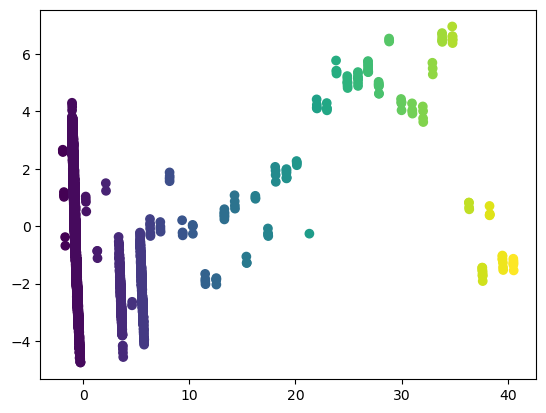

In [33]:
# Performing PCA so that we can plot the results

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components = 3)
Xt = pca.fit_transform(final_data)
plot = plt.scatter(Xt[:,0], Xt[:, 1], c=labels)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


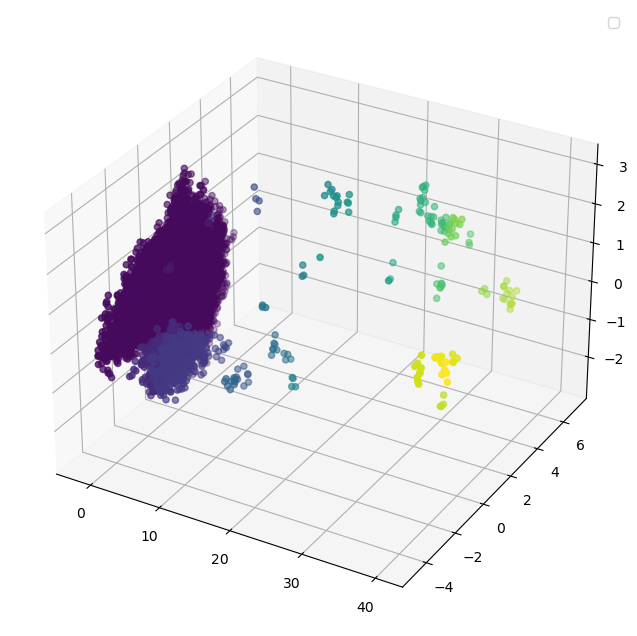

In [34]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(Xt[:,0], Xt[:,1], Xt[:,2], c=labels)
plt.legend()
plt.show()

## Performing traditional DBSCAN and KMeans over the entire dataset

#### DBSCAN

In [43]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
df2 = pd.read_csv("telescope_data.csv").drop(['Unnamed: 0'], axis=1)
scaler = StandardScaler()
le = LabelEncoder()
df2['class'] = le.fit_transform(df2['class'])
scaled_X = scaler.fit_transform(df2.drop(['class'], axis=1))
scaled_X

array([[-0.57722602, -0.33680419, -0.38113037, ..., -0.40584194,
         0.47681587, -1.49786555],
       [-0.51096889, -0.57002666, -0.64859479, ..., -0.49009359,
        -0.81541816,  0.15312459],
       [ 2.56827756,  6.20585836,  2.61578306, ..., -2.18302986,
         1.88922413,  0.84263513],
       ...,
       [ 0.52392318,  1.38177927,  1.31887687, ..., -0.4665087 ,
         0.10163583,  0.83900338],
       [ 1.58775746,  2.98278123,  2.47337518, ..., -3.07720555,
         2.18525981,  2.87032093],
       [ 3.16145936,  1.67999288,  0.81314905, ...,  1.49930076,
         0.96101431,  1.05044239]])

In [50]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=3.0, min_samples=4).fit(scaled_X)
dbscan.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [49]:
df2["DBSCAN"] = dbscan.labels_
df2

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class,DBSCAN
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,0,0
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,0,0
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,0,0
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,0,0
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,1,0
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,1,0
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,1,0
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,1,0


#### KMeans++ with k = 2 

In [54]:
km = KMeans(n_clusters=2, init="k-means++", random_state=0, n_init="auto", max_iter=300).fit(scaled_X)
km.labels_

array([0, 0, 1, ..., 1, 1, 1])

In [55]:
df2['KMeans++'] = km.labels_
df2

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class,DBSCAN,KMeans++
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,0,0,0
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,0,0,0
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,0,0,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,0,0,0
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,1,0,0
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,1,0,0
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,1,0,1
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,1,0,1
